In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.optimize import root
import pandas as pd
%matplotlib inline
import scienceplots
plt.style.use('nature')
plt.rc('font', family = 'serif')
plt.rc('figure', figsize = (8,6))
plt.rc('xtick', labelsize = 9) 
plt.rc('ytick', labelsize = 9) 
plt.rc('axes', titlesize = 14)
plt.rc('axes', labelsize = 12)

import astropy.constants as const
import astropy.units as u
import math

G  = 6.6730831e-8
c  = 2.99792458e10
MeV_fm3_to_pa = 1.6021766e35
c_km = 2.99792458e5 # km/s
mN = 1.67e-24 # g
mev_to_ergs = 1.602176565e-6
fm_to_cm = 1.0e-13
ergs_to_mev = 1.0/mev_to_ergs
cm_to_fm = 1.0/fm_to_cm
Msun = 1.988435e33
MeV_fm3_to_pa_cgs = 1.6021766e33
km_to_mSun = G/c**2

hbarc3 = 197.32700288295746**3

nucleon_mass = 938.04

pi = math.pi

In [28]:
eos = pd.read_csv('example_eos.dat', delimiter = ' ')

In [3]:
eos = pd.read_csv('eos_unified_FSUGarnet.dat', names = ["nB" ,"energy_density", "pressure"], skiprows = 1, delimiter = ' ')

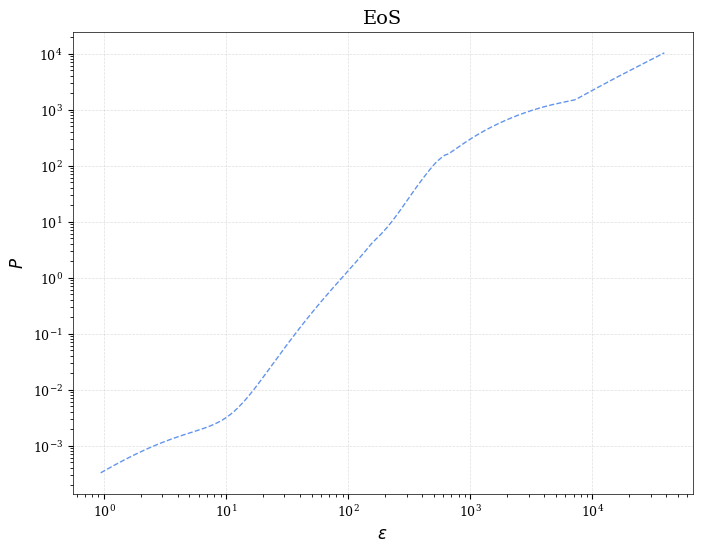

In [29]:
plt.plot(eos['energy_density'], eos['pressure'], color = 'cornflowerblue', linestyle = '--', markersize = 2)
plt.xlabel('$\epsilon$')
plt.ylabel('$P$')
plt.grid(alpha = 0.4, linestyle = '--')
plt.title('EoS')
plt.xscale('log')
plt.yscale('log')

In [30]:
eos['energy_density'] *= MeV_fm3_to_pa_cgs/c**2
eos['pressure'] *= MeV_fm3_to_pa_cgs

In [31]:
eos

,energy_density,pressure
0,1.672312e+12,5.232945e+29
1,1.755983e+12,5.559155e+29
2,1.843779e+12,5.903804e+29
3,1.936001e+12,6.266205e+29
4,2.032837e+12,6.646760e+29
...,...,...
193,5.404378e+16,1.250684e+37
194,5.746621e+16,1.340477e+37
195,6.111164e+16,1.437290e+37
196,6.499517e+16,1.541271e+37


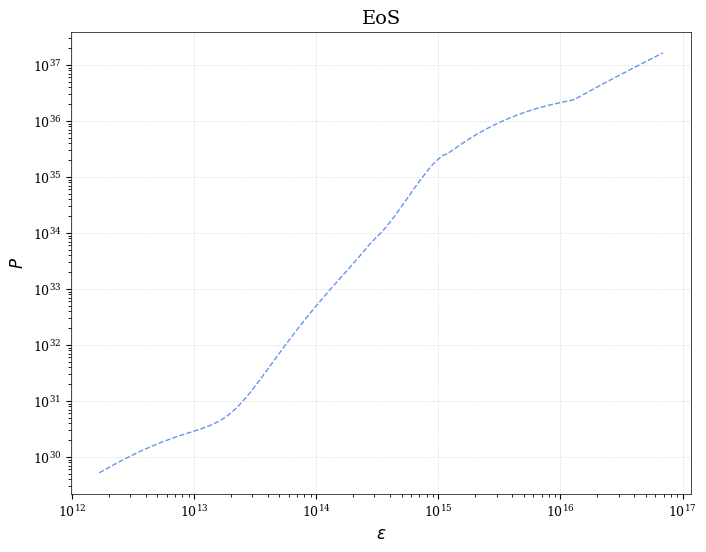

In [32]:
plt.plot(eos['energy_density'], eos['pressure'], color = 'cornflowerblue', linestyle = '--', markersize = 2)
plt.xlabel('$\epsilon$')
plt.ylabel('$P$')
plt.grid(alpha = 0.4, linestyle = '--')
plt.title('EoS')
plt.xscale('log')
plt.yscale('log')

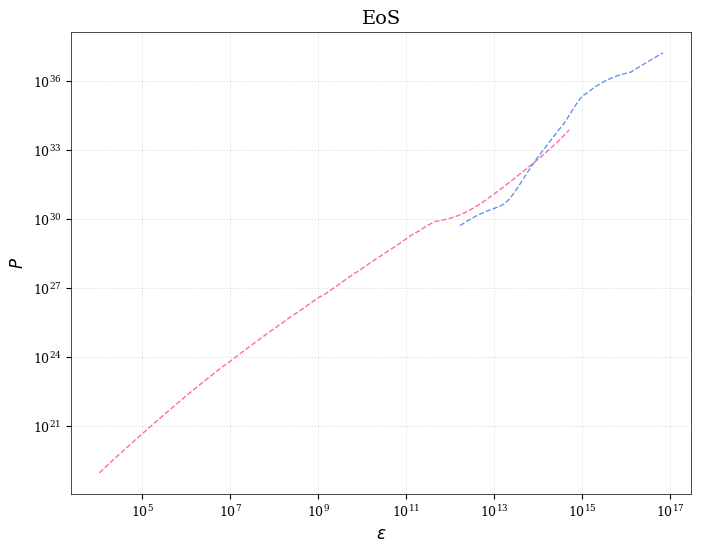

In [33]:
plt.plot(baym_eos['en'], baym_eos['p'], color = 'hotpink', linestyle = '--', markersize = 2)
plt.plot(eos['energy_density'], eos['pressure'], color = 'cornflowerblue', linestyle = '--', markersize = 2)
plt.xlabel('$\epsilon$')
plt.ylabel('$P$')
plt.grid(alpha = 0.4, linestyle = '--')
plt.title('EoS')
plt.xscale('log')
plt.yscale('log')

In [34]:
eps_sort = np.argsort(eos['pressure'])
eps = interp1d(eos['pressure'][eps_sort], eos['energy_density'][eps_sort], 'cubic')
press_sort = np.argsort(eos['energy_density'])
press = interp1d(eos['energy_density'][press_sort], eos['pressure'][press_sort], kind='cubic')

In [35]:
baym_eos = np.genfromtxt("data/Baym_eos.dat", 
                     dtype=float, skip_header=1,
                     names=["en", "p", "nB",])
P_crust = interp1d(baym_eos["en"], baym_eos["p"], kind = 'cubic') 
def eq_glue(n):
      return P_crust(n) - press(n)
g = root(eq_glue, [44.*(MeV_fm3_to_pa_cgs / c**2)], options = {'maxfev' : 200})
n_glue = g['x'][0]
en_arr = []
p_arr = []

for i in range(len(baym_eos["p"])):
    if baym_eos["en"][i] < n_glue:
        en_arr.append(baym_eos["en"][i])
        p_arr.append(baym_eos["p"][i])
    else:
        break
        
glue_ind = i

for i in range(len(eos['pressure'])):
    if eos['energy_density'][i] >= n_glue:
        en_arr.append(eos['energy_density'][i])
        p_arr.append(eos['pressure'][i])
        
en_arr = np.array(en_arr)
p_arr = np.array(p_arr)

eps_sort = np.argsort(eos['pressure'])
eps = interp1d(p_arr, en_arr, kind='cubic')
press_sort = np.argsort(eos['energy_density'])
press = interp1d(en_arr, p_arr, kind='cubic')

In [36]:
TOV_PARAMS = {"minP": np.min(eos['pressure']), "maxP": np.max(eos['pressure']), "minE": np.min(eos['energy_density']), "maxE": np.max(eos['energy_density'])}

In [37]:
def tov(y, r):
    P, m = y
    
    if P < TOV_PARAMS['minP'] or P > TOV_PARAMS['maxP']:
        return [0,0]
    
    edens = eps(P)
    dp_dr = (-G * ( edens + P / c**2) * (m + 4*np.pi*(r** 3)* P / c**2) ) / (r * (r - 2*G*m/c**2))
    dm_dr = 4*np.pi*(r**2)*edens
    
    return [dp_dr, dm_dr]

In [38]:
def solve_tov(e_c, r_max = 30e5, dr=100):

    e_c *= MeV_fm3_to_pa_cgs/c**2
    r = np.arange(dr, r_max + dr, dr)

    P = press(e_c)
    edens = eps(P)
    m = 4.0 * np.pi * (r[0] ** 3) * edens

    psol = odeint(tov, [P, m], r, rtol = 1e-5)

    p_R, m_R = psol[:,0], psol[:,1]
    
    del_slope = np.ediff1d(m_R[1:] - m_R[:-1])
    ind = np.argmin(del_slope)

    M = m_R[ind - 1]
    R = r[ind - 1]

    r   = r[:ind]
    p_R = p_R[:ind]
    m_R = m_R[:ind]
    
    e_R = eps(p_R)
    
    return R / 1e5, M / Msun, (r, e_R, p_R, m_R)

In [39]:
r = np.arange(100, 20e5, 100)

P = press(1e14)
edens = eps(P)
m = 4.0 * np.pi * (r[0] ** 3) * edens / c**2
print(m/Msun)

psol = odeint(tov, [P, m], r, rtol = 1e-5)

7.031561179336421e-34
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D+03   r2 =  0.3522258289878D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D+03   r2 =  0.3522258289878D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D+03   r2 =  0.3522258289878D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D+03   r2 =  0.3522258289878D-17
 lsoda--  warn

In [40]:
p_R, m_R = psol[:,0], psol[:,1]

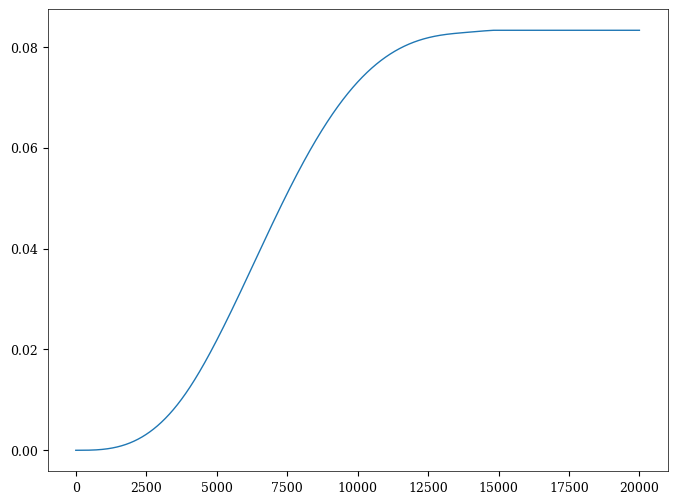

In [41]:
plt.plot(m_R/Msun)

In [42]:
o1, o2, o3 = solve_tov(5000)

In [43]:
o1, o2

(6.075, 0.975931729461721)

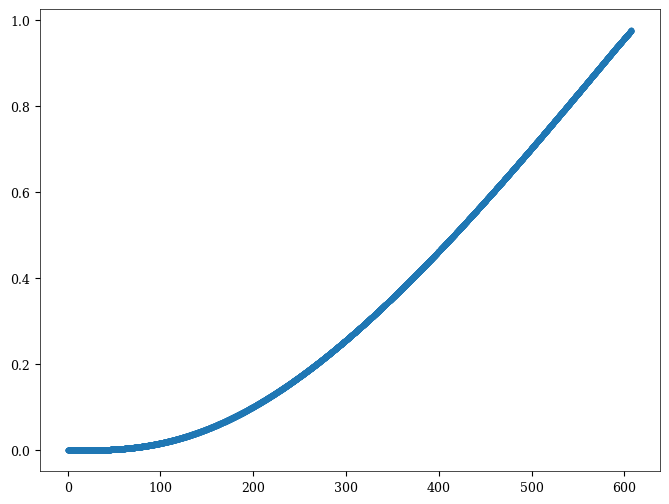

In [44]:
plt.plot(o3[0]/1e3, o3[-1]/Msun, marker = 'o')

In [45]:
m_arr = []
R_arr = []
dc = []

for dens_c in np.logspace(-0, 3.7, 350):
    try:
        R, M, prof = solve_tov(dens_c, r_max=50e5, dr=100)
        m_arr.append(M)
        R_arr.append(R)
        dc.append(dens_c)
    except:
        pass

/home/aswin/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


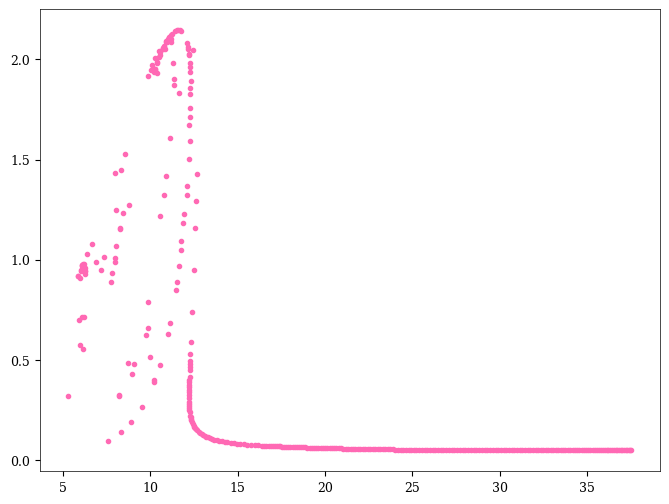

In [46]:
# plt.scatter(R_arr2, m_arr2, marker = 'o', color = 'orange')
# plt.scatter(R_arr1, m_arr1, marker = 'o', color = 'blue')
plt.scatter(R_arr, m_arr, marker = 'o', color = 'hotpink')
# plt.xlim(10, 20)

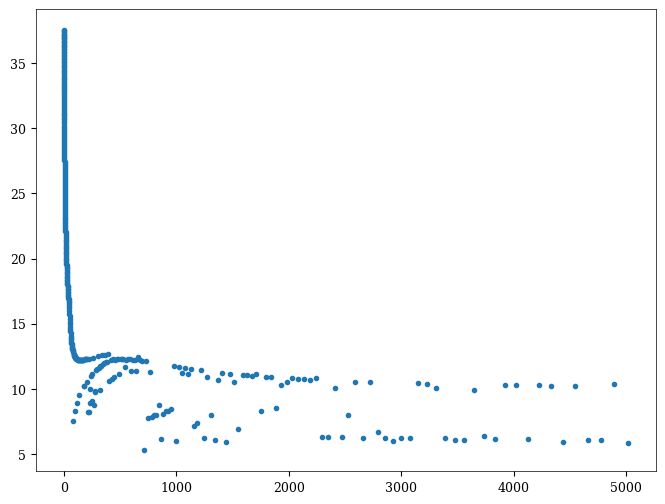

In [333]:
plt.scatter(dc, R_arr)

In [253]:
m_arr2 = m_arr
R_arr2 = R_arr